# **Applications of Deep Learning to Ocean Data Inference and Subgrid Parameterization**
### Thomas Bolton and Laure Zanna
----

##### *Marti and Morgan* #####
----

In this project, we aim to predict high-resolution oceanographic data from low-resolution inputs using a convolutional neural network (CNN). This technique is similar to super-resolution in image processing and can help enhance the resolution and detail of environmental data, which is crucial for accurate scientific analysis and prediction.

In their paper, Bolton and Zanna use degraded data from a high-resolution ocean model, and found they could subsample down to 10-20% of the original size and still be very accurate. They were also able to predict subsurface ocean circulation, as well as predicting both subgrid and large-scale processes.

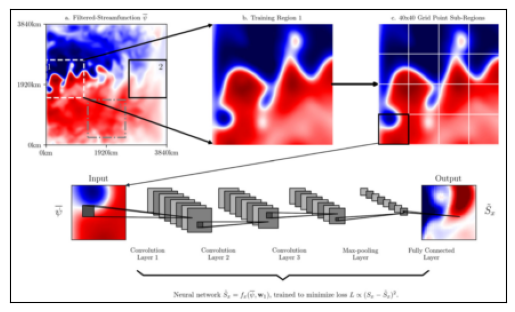

In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from images import show_image, load_image

ocean = load_image('ocean.png')
show_image(ocean)

We generate synthetic data that mimics low-resolution and high-resolution oceanographic measurements. We use an exponential fraction to mirror the current rate of changes in the environment. The model aims to learn how to reconstruct or predict this high-resolution data from the given low-resolution data.

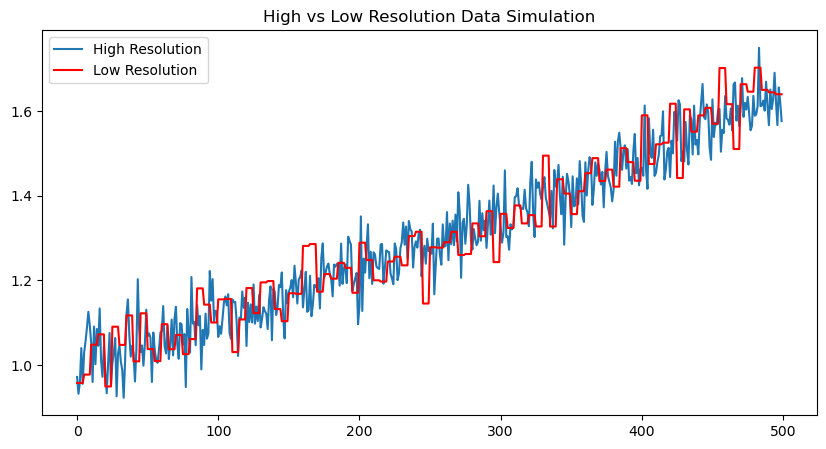

In [85]:
def generate_data(size):
    x = np.linspace(0, 10, size)
    highres = np.exp(0.05*x) +np.random.normal(0, 0.05, size)
    lowres = np.exp(0.05*x[::5]) +np.random.normal(0, 0.05, size//5)
    return highres, np.repeat(lowres, 5)

highres, lowres = generate_data(6400)

a,b = generate_data(500)
plt.figure(figsize=(10, 5))
plt.plot(a, label='High Resolution')
plt.plot(b, label='Low Resolution', color = 'red')
plt.legend()
plt.title("High vs Low Resolution Data Simulation")
plt.show()

`generate_data` returns flat arrays. A CNN expects inputs of the shape `(batch_size, channels, height, width)`, so we need to reshape the outputs.

In [86]:
highres = highres.reshape(-1, 1, 40, 40)
lowres = lowres.reshape(-1, 1, 40, 40)

We then split the data into train and test sets. `lowres` is the sample we're gonna apply the CNN to to predict the high-resolution data. `target` is the high-resolution data we're going to compare the output to.

In [87]:
def split_data(lowres, target, split=0.25):
    num_samples = lowres.shape[0]
    num_train = int(num_samples * (1-split))

    indices = np.arange(num_samples)
    np.random.shuffle(indices)

    train_idx = indices[:num_train]
    test_idx = indices[num_train:]

    return lowres[train_idx], target[train_idx], lowres[test_idx], target[test_idx]

X_train, y_train, X_test, y_test = split_data(highres, lowres)

We need to convert these numpy arrays into tensors. 

In [88]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

We use DataLoader to iterate over the data. TensorDataset wraps tensors into a dataset, pairing the low-resolution input data with the corresponding high-resolution target data.

In [89]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=16)

For the CNN, we used some of the same functions as the paper, including SeLU and Adam. We also used the same parameters for constructing the neural network.

- `conv2D` is a built in method in torch.nn package that applies a 2D convolution over an input composed of several input planes.
- `maxPool2d1` is a built in method in torch.nn package that applies a 2D max pooling over an input signal composed of several input planes.

In [90]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=8, stride=2, padding=3)
        self.selu1 = nn.SELU()
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(16, 128, kernel_size=4, stride=1, padding=1)
        self.selu2 = nn.SELU()
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(128, 64, kernel_size=4, stride=1, padding=1)
        self.selu3 = nn.SELU()
        self.pool3 = nn.MaxPool2d(2)

        self.upconv = nn.ConvTranspose2d(64, 1, kernel_size=40, stride=16, padding=0)

    def forward(self, x):
        x = self.selu1(self.conv1(x))
        x = self.pool1(x)
        x = self.selu2(self.conv2(x))
        x = self.pool2(x)
        x = self.selu3(self.conv3(x))
        x = self.pool3(x)
        x = self.upconv(x)
        return x

model = CNN()

Training and evaluation:

 - MSE works by calculating the square of the difference between predicted values and actual values, then averaging these squares over the entire dataset.
 - `Adam` is an adaptive learning rate optimization algorithm

In [91]:
loss_f = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 200
epoch_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    count = 0

    for data, targets in train_loader:
        optimizer.zero_grad() # clear old gradients
        outputs = model(data)
        loss = loss_f(outputs, targets)
        loss.backward() # calculates gradients of loss wrt parameters of model
        optimizer.step()
        total_loss += loss.item()
        count += 1

    avg_loss = total_loss/count
    epoch_losses.append(avg_loss)

model.eval()
total_loss = 0
with torch.no_grad():
    for data, targets in test_loader:
       outputs = model(data)
       loss = loss_f(outputs, targets)
       total_loss += loss.item()

average_loss = total_loss / len(test_loader)
print(f'Average Loss: {average_loss:.4f}')

Average Loss: 0.0027


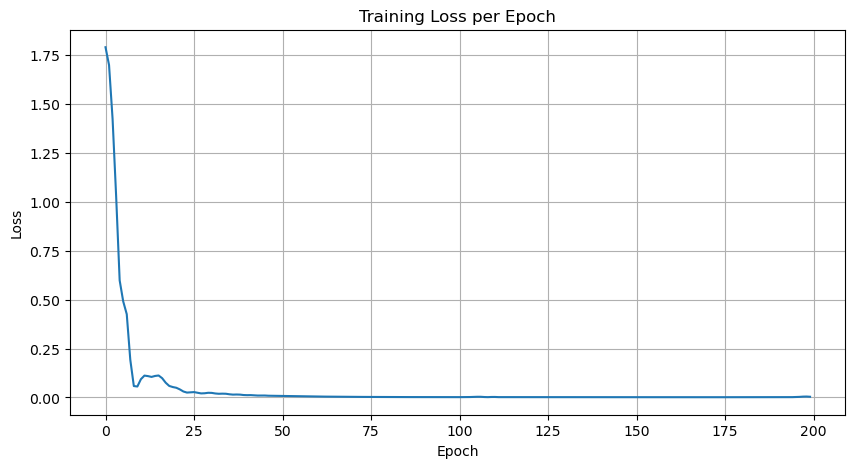

In [92]:
def plot_epoch_losses(epoch_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(epoch_losses, label='Training Loss')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

plot_epoch_losses(epoch_losses)

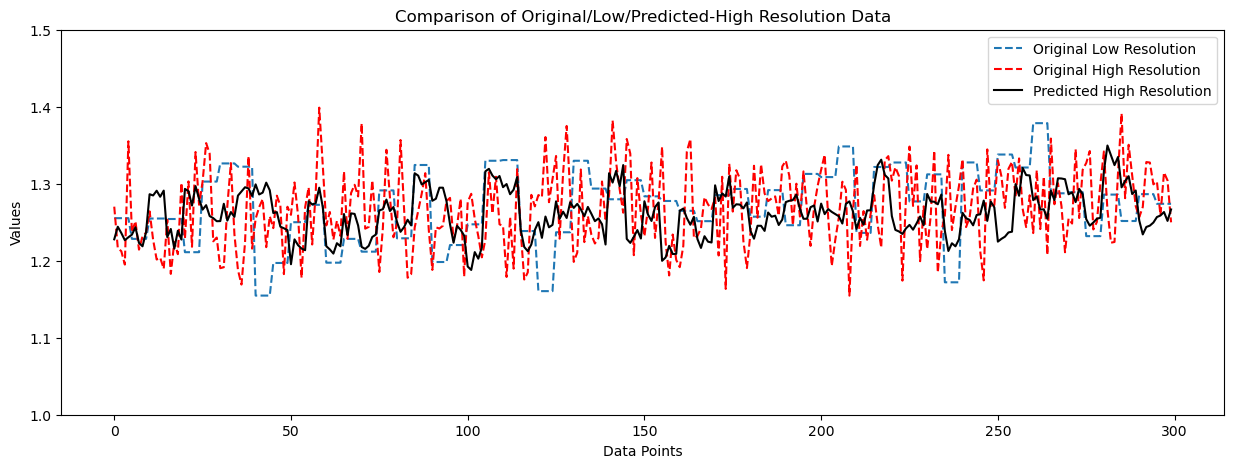

In [93]:
model.eval()
pred = []

with torch.no_grad():
    for data, targets in test_loader:
        outputs = model(data)
        pred.extend(outputs.cpu().numpy().reshape(-1, 1600))

pred = np.concatenate(pred, axis=0).reshape(-1)
high300 = y_test.reshape(-1)[-300:].numpy()
low300 = X_test.reshape(-1)[-300:].numpy()
pred300 = pred[-300:]

plt.figure(figsize=(15, 5))
plt.plot(high300, label='Original Low Resolution', linestyle='--')
plt.plot(low300, label='Original High Resolution', color='red', linestyle='--')
plt.plot(pred300, label='Predicted High Resolution', color='black')
plt.legend()
plt.title("Comparison of Original/Low/Predicted-High Resolution Data")
plt.xlabel("Data Points")
plt.ylabel("Values")
plt.ylim(1,1.5)
plt.show()